In [67]:
from sklearn import preprocessing
import numpy as np
import pandas as pd

df = pd.read_csv("nuclear/data.csv")

In [68]:
df_2d= df.drop(columns = ['AP', 'RH', "PE"])
# df_2d = df.drop(columns = ['z'])


In [69]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_2d = scaler.fit_transform(df_2d)
# df_2d = preprocessing.scale(df_2d)

In [70]:
import matplotlib.pyplot as plt

# df_2d = df_2d[:10000,]

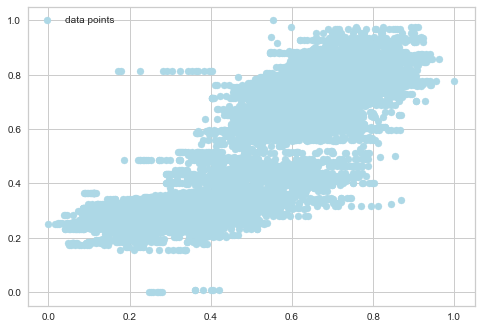

In [71]:

# df_2d=  df_2d[:10000,]
fig,ax = plt.subplots(1)


x = df_2d[:,0]
y = df_2d[:,1]

ax.scatter(x, y, color='lightblue', label='data points')
ax.legend(loc='upper left')


In [72]:
num_elements = 5000
minX = min(x)
maxX = max(x)
Q1 = np.random.uniform(minX, maxX, num_elements)

minY = min(y)
maxY = max(y)
Q2 = np.random.uniform(minY, maxY, num_elements)
# fig2 = plt.figure()
# ax2 = fig2.add_subplot()
# plt.plot(Q1, Q2, 'o', c="red")
# plt.show()

In [73]:
# L is half the length of the rectangle
maxSize  =max(maxX, maxY)/3
L = np.random.uniform(low = 0, high= maxSize/2, size = num_elements)


In [74]:
query_lst = []
for Q1_, Q2_, L_ in zip(Q1, Q2, L):
    query = [Q1_, Q2_, L_, L_]
    query_lst.append(query)

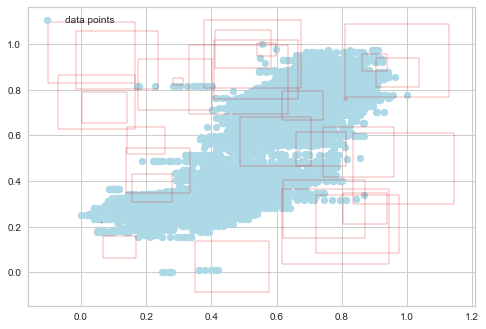

In [75]:
import matplotlib.patches as patches

fig,ax = plt.subplots(1)
# x = df_2d[:,0]
# y = df_2d[:,1]

ax.scatter(x, y, color='lightblue', label='data points')
ax.legend(loc='upper left')


for query in query_lst [:30]:
    # Leftmost point of square
    a,b = query[0] - query[2], query[1] - query[3]
    # Assumes Square
    length = query[3] * 2

    rect = patches.Rectangle((a,b),length, length, edgecolor='r', fill=False, zorder=2, label = "query range")
    # currentAxis = plt.gca()
    ax.add_patch(rect)


plt.show()


In [76]:
def inRange (Q, X1, X2):
    Q1 = Q[0]
    Q2 = Q[1]
    L1 = Q[2]
    L2 = Q[3]

    if (Q1 - L1 <= X1 and X1 <= Q1 +L1) and (Q2 - L2 <= X2 and X2 <= Q2 +L2):
        return True
    return False

In [77]:
from scipy.stats import pearsonr
import math
import statistics
from sklearn.linear_model import LinearRegression
def getResults(query_lst, X1, X2):
    results = []
    for _Q in query_lst:
        count = 0
        valid_X1_lst =[]
        valid_X2_lst =[]
        df = []
        for _X1, _X2 in zip(X1, X2):
            if inRange(_Q, _X1, _X2):
                count+=1
                valid_X1_lst.append(_X1)
                valid_X2_lst.append(_X2)
                df.append([_X1, _X2])
        
        if count >=2:
            Q_dict = {
                'query': _Q, 
                'count': count,
                "x1_avr": np.mean(valid_X1_lst), 
                "x2_avr": np.mean(valid_X2_lst), 
                'pearson': pearsonr(valid_X1_lst, valid_X2_lst)[0],
                'X1_reg_coef':  statistics.mean(LinearRegression().fit(df,valid_X1_lst).coef_),
                'X2_reg_coef':  statistics.mean(LinearRegression().fit(df,valid_X2_lst).coef_)
            }
            add =True
            for v in Q_dict.values():
                if isinstance(v, list)!=True: 
                
                    if math.isnan(v):
                        add =False
                
            if add: 
                results.append(Q_dict)

    return results

    

In [78]:
from sklearn.model_selection import train_test_split


def get_training_data(y_parameter):
    data = getResults(query_lst, x ,y)
    queries = [query_dict["query"] for query_dict in data]
    results = [query_dict[y_parameter] for query_dict in data]
    return queries, results, data

In [79]:
from sklearn.model_selection import train_test_split


def get_training_data_split(y_parameter):
    data = getResults(query_lst, x ,y)
    queries = [query_dict["query"] for query_dict in data]
    results = [query_dict[y_parameter] for query_dict in data]
    train_data, validation_data, train_labels, validation_labels = train_test_split(queries, results, test_size=0.2)

    print('Training set contains {:d} rows.'.format(len(train_data)))
    print('Vadlidation set contains {:d} rows.'.format(len(validation_data)))

    return train_data, train_labels, validation_data, validation_labels

In [80]:
train_data, train_labels, rawData = get_training_data("count")

In [81]:
td,tl,vd,vl  = get_training_data_split("count")

Training set contains 2448 rows.
Vadlidation set contains 612 rows.


In [82]:
from sklearn.metrics import make_scorer
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
smape_scorer=  make_scorer(smape, greater_is_better=False)

In [83]:

import sklearn.metrics as metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean

def globalModelPrediction(model, name):
    cv = KFold(n_splits=10, random_state=1, shuffle=True)

    scores_smape = cross_val_score(model, train_data, train_labels, scoring=smape_scorer, cv=cv, n_jobs=-1)
 
    print("Symmetric Mean Absolute Percentage Error for " + name + ": " + str(int(mean(np.absolute(scores_smape))))+"%")

    scores_mae = cross_val_score(model, train_data, train_labels, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
 
    print("Mean Absolute Error for " + name + ": " + str(int(mean(np.absolute(scores_mae)))))

    scores_r2 = cross_val_score(model, train_data, train_labels, scoring='r2', cv=cv, n_jobs=-1)
 
    print("R2 Score for " + name + ": " + str(round(mean(scores_r2), 2)))

In [84]:

# import sklearn.metrics as metrics
# from numpy import mean

# def globalModelPrediction2(model, name):
#     model.fit(td,tl)
#     vp = model.predict(vd)
#     print('Mean absolute error: %.2f'
#       % metrics.mean_absolute_error(vl, vp))
    

In [85]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
globalModelPrediction(lr, "Linear Regression")

Symmetric Mean Absolute Percentage Error for Linear Regression: 103%
Mean Absolute Error for Linear Regression: 464
R2 Score for Linear Regression: 0.23


In [86]:
from sklearn import svm
globalModelPrediction(svm.SVR(), "Support Vector Regression")

Symmetric Mean Absolute Percentage Error for Support Vector Regression: 109%
Mean Absolute Error for Support Vector Regression: 467
R2 Score for Support Vector Regression: -0.16


In [87]:
from sklearn.neighbors import KNeighborsRegressor
globalModelPrediction(KNeighborsRegressor(), "K Nearest Neighbors Regression")


Symmetric Mean Absolute Percentage Error for K Nearest Neighbors Regression: 32%
Mean Absolute Error for K Nearest Neighbors Regression: 73
R2 Score for K Nearest Neighbors Regression: 0.97


In [88]:
from sklearn.gaussian_process import GaussianProcessRegressor
globalModelPrediction(GaussianProcessRegressor(), "Gaussian Process Regression")

Symmetric Mean Absolute Percentage Error for Gaussian Process Regression: 58%
Mean Absolute Error for Gaussian Process Regression: 85
R2 Score for Gaussian Process Regression: 0.97


In [89]:
from sklearn import tree
globalModelPrediction(tree.DecisionTreeRegressor(), "Decision Tree Regression")


Symmetric Mean Absolute Percentage Error for Decision Tree Regression: 42%
Mean Absolute Error for Decision Tree Regression: 120
R2 Score for Decision Tree Regression: 0.92


In [90]:
from sklearn.ensemble import AdaBoostRegressor
globalModelPrediction(AdaBoostRegressor(), "Ada Boost Regression")


Symmetric Mean Absolute Percentage Error for Ada Boost Regression: 95%
Mean Absolute Error for Ada Boost Regression: 418
R2 Score for Ada Boost Regression: 0.43


In [91]:
# from yellowbrick.cluster import KElbowVisualizer
# from sklearn.cluster import KMeans
# visualizer = KElbowVisualizer(KMeans(), k=(1,12))
# visualizer.fit(np.array(train_data))        # Fit the data to the visualizer
# visualizer.show()  

In [92]:
# from sklearn.cluster import KMeans

# k = visualizer.elbow_value_
# cluster_data = {i: {'count': 0 , 'data': [], 'labels': []} for i in range(k)}
# kmeans = KMeans(n_clusters=k).fit(train_data)
# for raw_query, query, label, cluster_id in zip(train_data, train_data, train_labels, kmeans.labels_):
#     cluster_data[cluster_id]['data'].append(query)
#     cluster_data[cluster_id]['labels'].append(label)
#     cluster_data[cluster_id]["count"]+=1


In [97]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import copy

def build_cluster_data(train_data, train_labels, model):
    visualizer = KElbowVisualizer(KMeans(), k=(1,12))
    visualizer.fit(np.array(train_data))
    visualizer.show()
    k = visualizer.elbow_value_
    cluster_data = {i: {'data': [], 'labels': []} for i in range(k)}
    kmeans = KMeans(n_clusters=k).fit(train_data)
    for query, label, cluster_id in zip(train_data, train_labels, kmeans.labels_):
        cluster_data[cluster_id]['data'].append(query)
        cluster_data[cluster_id]['labels'].append(label)
       
    m = copy.deepcopy(model)
    for cluster in cluster_data.values():
        m.fit(cluster['data'], cluster['labels'])
        cluster["model"] = model

    return cluster_data, kmeans

In [99]:
import sklearn.metrics as metrics
from numpy import mean

def validate_data(validation_data, validation_labels, kmeans):
    validation_cluster_data = {i: {'data': [], 'labels': []} for i in range(k)}
    predicted_clusters  = kmeans.predict(validation_data)
    for query, label, cluster_id in zip(validation_data, validation_labels, predicted_clusters):
        validation_cluster_data[cluster_id]['data'].append(query)
        validation_cluster_data[cluster_id]['labels'].append(label)

    mae_list = []
    r2_list = []
    smape_list = []
    for cluster_key, cluster in cluster_data.items():
        cvd =  validation_cluster_data[cluster_key]['data']
        cvl =  validation_cluster_data[cluster_key]['labels']
        model = cluster['model']
        cvp = model.predict(cvd)
        
        smape_list.append(smape(cvl, cvp))
        mae_list.append(metrics.mean_absolute_error(cvl, cvp))
        r2_list.append(metrics.r2_score(cvl, cvp))

    print("Symmetric Mean Absolute Percentage Error:"  + str(int(mean(smape_list)))+"%")

    print("Mean Absolute Error: " + str(int(mean(mae_list))))

    print("R2 Score: " + str(round(mean(r2_list), 2)))
    return validation_cluster_data

In [95]:
def print_clusters(cluster_data):
    colors = ['red', "blue", 'black', 'green']
    fig,ax = plt.subplots(1)

    for label, cluster, color  in zip(cluster_data.keys(), cluster_data.values(), colors):
        x = [i[0] for i in cluster['data']]
        y = [i[1] for i in cluster['data']]   
        ax.scatter(x, y, color=color, label='Cluster: ' + str(label))
        ax.legend(loc='upper left')
    a = [i[0] for i in kmeans.cluster_centers_]
    b = [i[1] for i in kmeans.cluster_centers_]
    ax.scatter(a, b, color="yellow")

Symmetric Mean Absolute Percentage Error:38%
Mean Absolute Error: 78
R2 Score: 0.96


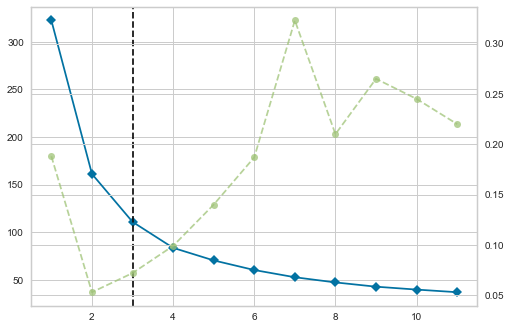

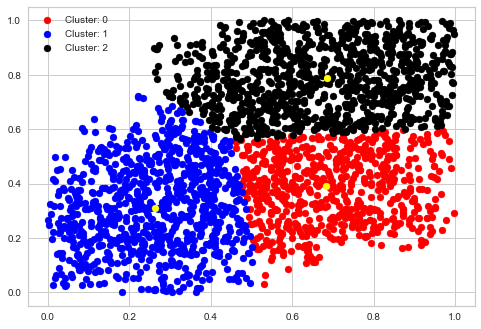

In [100]:
from sklearn.neighbors import KNeighborsRegressor

a, lmeans = build_cluster_data(td, tl, KNeighborsRegressor())
b = validate_data(vd, vl, kmeans)
print_clusters(a)

In [65]:
# import pandas as pd
# from sklearn.neighbors import KNeighborsRegressor
# rawDataFrame = pd.DataFrame.from_dict(rawData)
# for cluster in cluster_data.values():
#     model = KNeighborsRegressor()
#     model.fit(cluster['data'], cluster['labels'])
#     cluster["model"] = model



In [66]:
# import sklearn.metrics as metrics
# from numpy import mean

# validation_cluster_data = {i: {'count': 0 , 'data': [], 'labels': []} for i in range(k)}
# predicted_clusters  = kmeans.predict(vd)
# for query, label, cluster_id in zip(vd, vl, predicted_clusters):
#     validation_cluster_data[cluster_id]['data'].append(query)
#     validation_cluster_data[cluster_id]['labels'].append(label)
#     validation_cluster_data[cluster_id]["count"]+=1

# mae_list = []
# r2_list = []
# smape_list = []
# for idd, cluster in cluster_data.items():
#     cvd =  validation_cluster_data[idd]['data']
#     cvl =  validation_cluster_data[idd]['labels']
#     model = cluster['model']
#     cvp = model.predict(cvd)
    
#     smape_list.append(smape(cvl, cvp))
#     mae_list.append(metrics.mean_absolute_error(cvl, cvp))
#     r2_list.append(metrics.r2_score(cvl, cvp))

# print("Symmetric Mean Absolute Percentage Error:"  + str(int(mean(smape_list)))+"%")

# print("Mean Absolute Error: " + str(int(mean(mae_list))))

# print("R2 Score: " + str(round(mean(r2_list), 2)))
    
# # print("Symmetric Mean Absolute Percentage Error for " + name + ": " + str(int(mean(np.absolute(scores_smape))))+"%")

# # print("Mean Absolute Error for " + name + ": " + str(int(mean(np.absolute(scores_mae)))))

# # print("R2 Score for " + name + ": " + str(round(mean(scores_r2), 2)))